In [1]:
import tensorflow as tf
import keras
import numpy as np
import copy

from numpy.typing import NDArray

tf.config.list_physical_devices('GPU')

2025-03-16 21:09:48.940795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742184588.958505   40665 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742184588.964030   40665 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 21:09:48.981744: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/gkouretas/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
data: NDArray = np.load("training_datasets.npy", allow_pickle=True)
labels: NDArray = np.load("training_labels.npy", allow_pickle=True)

In [3]:
data.shape, labels.shape

((34, 6, 4), (34, 6))

## Configuration values

In [4]:
MASK_VALUE = 0.0
WINDOW_SIZE_SEC = 10.0
STRIDE_SEC = 0.5
MAX_PREDICTED_LENGTH_SEC = 120.0
USE_CUSTOM_WEIGHTS = False
USE_CONV_LAYERS = True

In [5]:
SAMPLING_RATE_EMG = 1. / 1000
SAMPLING_RATE_BPM = 1. / 200
SAMPLING_RATE_IMU = 1. / 100

(98640,) 98.64
(19727,) 98.635
(9864,) 98.64
(9864,) 98.64
(98000,) 98.0
(58570,) 58.57
(11713,) 58.565
(5857,) 58.57
(5857,) 58.57
(57000,) 57.0


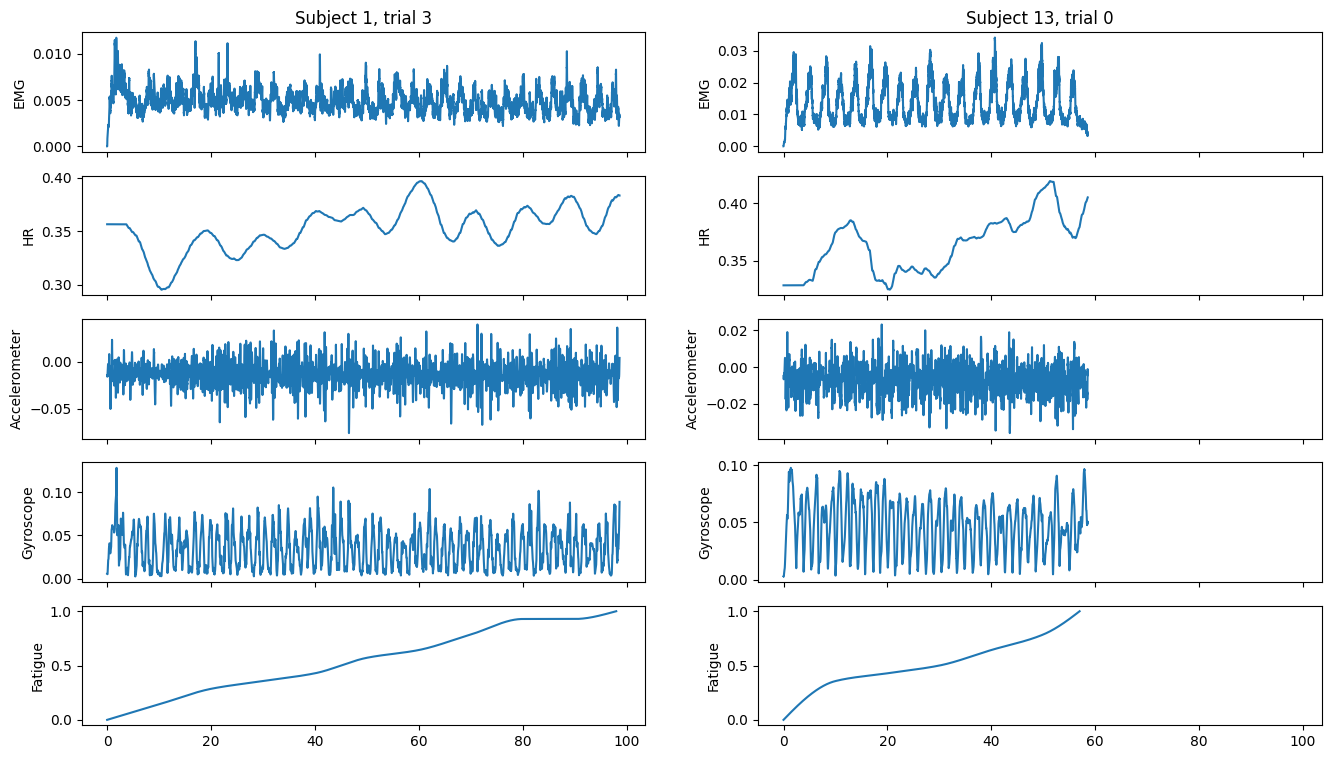

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

signals = ("EMG", "HR", "Accelerometer", "Gyroscope", "Fatigue")
sampling_rates = (SAMPLING_RATE_EMG, SAMPLING_RATE_BPM, SAMPLING_RATE_IMU, SAMPLING_RATE_IMU, SAMPLING_RATE_EMG)

n_images = 2
fig, ax = plt.subplots(len(signals), n_images, sharex=True, figsize=(16,9))

for i in range(n_images):
    subject = np.random.randint(0, data.shape[0])
    trial = np.random.randint(0, data.shape[1])

    ax[0][i].set_title(f"Subject {subject}, trial {trial}")

    for j in range(len(signals)):
        if j == len(signals)-1:
            signal: NDArray = labels[subject][trial]
        else:
            signal: NDArray = data[subject][trial][j]

        print(signal.shape, sampling_rates[j]*signal.size)

        ax[j][i].plot(
            np.linspace(0.0, sampling_rates[j]*signal.size, signal.size), 
            signal
        )

        ax[j][i].set_ylabel(signals[j])

In [7]:
from enum import IntEnum, auto

class FatigueInputs(IntEnum):
    EMG = auto()
    HR = auto()
    ACCEL = auto()
    GYRO = auto()

class FatigueLSTMBlock(keras.models.Model):
    def __init__(self, weight: float | None, mask: float | None = None, lstm_kwargs: dict = {}, conv_layers_kwargs: list[dict] | None = None, **kwargs):
        super().__init__(**kwargs)

        self._weight = weight
        self._mask = mask

        if conv_layers_kwargs is not None:
            self._conv_layers: list[keras.layers.Conv1D] = []
            for conv_kwargs in conv_layers_kwargs:
                self._conv_layers.append(keras.layers.Conv1D(**conv_kwargs))
        else:
            self._conv_layers = None
        
        if mask is None:
            self._mask_layer = None
        else:
            self._mask_layer = keras.layers.Masking(mask_value=mask)

        self._lstm_layer = keras.layers.LSTM(
            **lstm_kwargs
        )

        self._classification_layer = keras.layers.Dense(
            1,
            activation="sigmoid",
        )

        self._scale_layer = None
        if weight is not None:
            self._scale_layer = keras.layers.Lambda(
                lambda x: x * self._weight
            )

        self._output_shape = None
        self._last_pred = None
    
    @property
    def weight(self):
        return self._weight
    
    @property
    def mask(self):
        return self._mask

    @property
    def last_prediction(self):
        return self._last_pred

    @property
    def output_layer(self):
        return self._classification_layer
    
    @property
    def output_shape(self):
        return self._output_shape

    def build(self, input_shape):
        if self._conv_layers is not None:
            for conv_layer in self._conv_layers:
                conv_layer.build(input_shape)
                input_shape = conv_layer.compute_output_shape(input_shape)
        
        if self._mask_layer is not None:
            self._mask_layer.build(input_shape)
            input_shape = self._mask_layer.compute_output_shape(input_shape)

        self._lstm_layer.build(input_shape)
        input_shape = self._lstm_layer.compute_output_shape(input_shape)

        self._classification_layer.build(input_shape)
        input_shape = self._classification_layer.compute_output_shape(input_shape)

        if self._scale_layer is not None:
            self._scale_layer.build(input_shape)
            input_shape = self._scale_layer.compute_output_shape(input_shape)

        self._output_shape = input_shape

    def call(self, inputs):
        x = inputs
        if self._conv_layers is not None:
            for conv_layer in self._conv_layers:
                x = conv_layer(x)
                
        if self._mask_layer is not None:
            x = self._mask_layer(x)

        x = self._lstm_layer(x)
        x = self._classification_layer(x)
        if self._scale_layer is not None:
            x = self._scale_layer(x)

        return x
    
    def compute_output_shape(self, input_shape):
        if self._output_shape is None:
            self.build(input_shape)
            
        return self._output_shape
    
class FatigueClassifier(keras.models.Model):
    @staticmethod
    def preprocess_signal(signal: NDArray, fs: float, window_size: float, stride: float, max_duration_sec: float, pad_value: float = 0.0):
        _size = int(fs*max_duration_sec)
        _window = int(fs*window_size)
        _stride = int(fs*stride)

        _output_signal = np.zeros((signal.shape[0], int((_size-_window)/_stride), _window))
        
        for i in range(signal.shape[0]):
            for j, k in enumerate(range(0, _size-_window, _stride)):
                if k >= signal[i].size:
                    _output_signal[i][j] = np.ones(shape = (1, _window)) * pad_value
                elif k+_window >= signal[i].size:
                    _output_signal[i][j] = np.concatenate(
                        [np.array(signal[i][k:signal[i].size]).reshape((1, signal[i][k:signal[i].size].size)), np.ones(shape = (1, _window-(signal[i].size-k))) * pad_value],
                        axis = 1
                    )
                else:
                    _output_signal[i][j] = signal[i][k:k+_window]

        return _output_signal
    
    @staticmethod
    def preprocess_labels(labels: NDArray, fs: float, window_size: float, stride: float, max_duration_sec: float, pad_value: float = 0.0):
        _size = int(fs*max_duration_sec)
        _window = int(fs*window_size)
        _stride = int(fs*stride)

        _output_signal = np.zeros((labels.shape[0], int((_size-_window)/_stride)))
        for i in range(labels.shape[0]):
            for j, k in enumerate(range(0, _size-_window, _stride)):
                if k+_window >= labels[i].size:
                    _output_signal[i][j] = pad_value
                else:
                    _output_signal[i][j] = labels[i][k+_window]

        return _output_signal

    @staticmethod
    def loss(y_true, y_pred, mask):
        if mask is not None:
            # Get boolean tensor where true = valid, false = invalid
            y_true_mask = tf.cast(y_true != mask, dtype=tf.float32)

            n_elem = tf.reduce_sum(y_true_mask)

            return tf.cond(tf.equal(n_elem, 0.0), lambda: 0.0, lambda: tf.reduce_sum(tf.square(y_true - y_pred) * y_true_mask) / n_elem)

        else:
            return keras.losses.mean_squared_error(y_true, y_pred)

    def __init__(self, lstm_blocks: list[FatigueLSTMBlock]):
        super().__init__()
        self._lstm_blocks = lstm_blocks
        
        assert all(x.weight is None for x in self._lstm_blocks) or np.sum([x.weight for x in lstm_blocks]) == 1.0, \
            "Sum of the weights must be equal to 1.0, or weights must all be None"
        assert np.all(np.asarray([x.mask for x in lstm_blocks]) == lstm_blocks[0].mask), \
            "All LSTM blocks must use the same mask"

        self._mask = lstm_blocks[0].mask
        self._hard_coded_weights = self._lstm_blocks[0].weight is not None

        self._reshape_layer: keras.layers.Concatenate | None
        self._classification_layer: keras.layers.Dense | keras.layers.Add | None

    def build(self, input_shape):
        output_shapes = []
        for lstm_block, input_vector in zip(self._lstm_blocks, input_shape):
            output_shapes.append(lstm_block.compute_output_shape(input_vector))

        if not self._hard_coded_weights:
            # Concatenate LSTM blocks
            self._reshape_layer = keras.layers.Concatenate(axis=-1)
            self._reshape_layer.build(output_shapes)
            input_shape = self._reshape_layer.compute_output_shape(output_shapes)

            # Single classification of fatigue from 0-1
            self._classification_layer = keras.layers.Dense(1, activation="sigmoid", name="fatigue_classification_layer")
            self._classification_layer.build(input_shape)
        else:
            # Classification layer is to simply sum the blocks together
            self._classification_layer = keras.layers.Add()
            self._classification_layer.build(output_shapes)

    def call(self, inputs):
        x = []
        for i, input_vector in enumerate(inputs):
            x.append(self._lstm_blocks[i](input_vector))

        if not self._hard_coded_weights:
            x = self._reshape_layer(x)
            # x = self._scale_layer(x)

        return self._classification_layer(x)
    
    def model_loss_function(self, y_true, y_pred):
        return FatigueClassifier.loss(y_true, y_pred, self._mask)

In [8]:
data.shape

(34, 6, 4)

In [9]:
combined_data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
combined_data.shape

(204, 4)

In [10]:
labels.shape

(34, 6)

In [11]:
combined_labels = labels.reshape((labels.shape[0]*labels.shape[1],))
combined_labels.shape

(204,)

In [12]:
inputs = {}

for i, Ts in enumerate(sampling_rates[:-1]):
    inputs[signals[i]] = FatigueClassifier.preprocess_signal(
        combined_data[..., i], 
        fs=1/Ts, 
        window_size=WINDOW_SIZE_SEC, 
        stride=STRIDE_SEC, 
        max_duration_sec=MAX_PREDICTED_LENGTH_SEC, 
        pad_value=MASK_VALUE
    )

outputs = FatigueClassifier.preprocess_labels(
    combined_labels, 
    fs=1000, 
    window_size=WINDOW_SIZE_SEC, 
    stride=STRIDE_SEC, 
    max_duration_sec=MAX_PREDICTED_LENGTH_SEC, 
    pad_value=MASK_VALUE
)

outputs.shape

(204, 220)

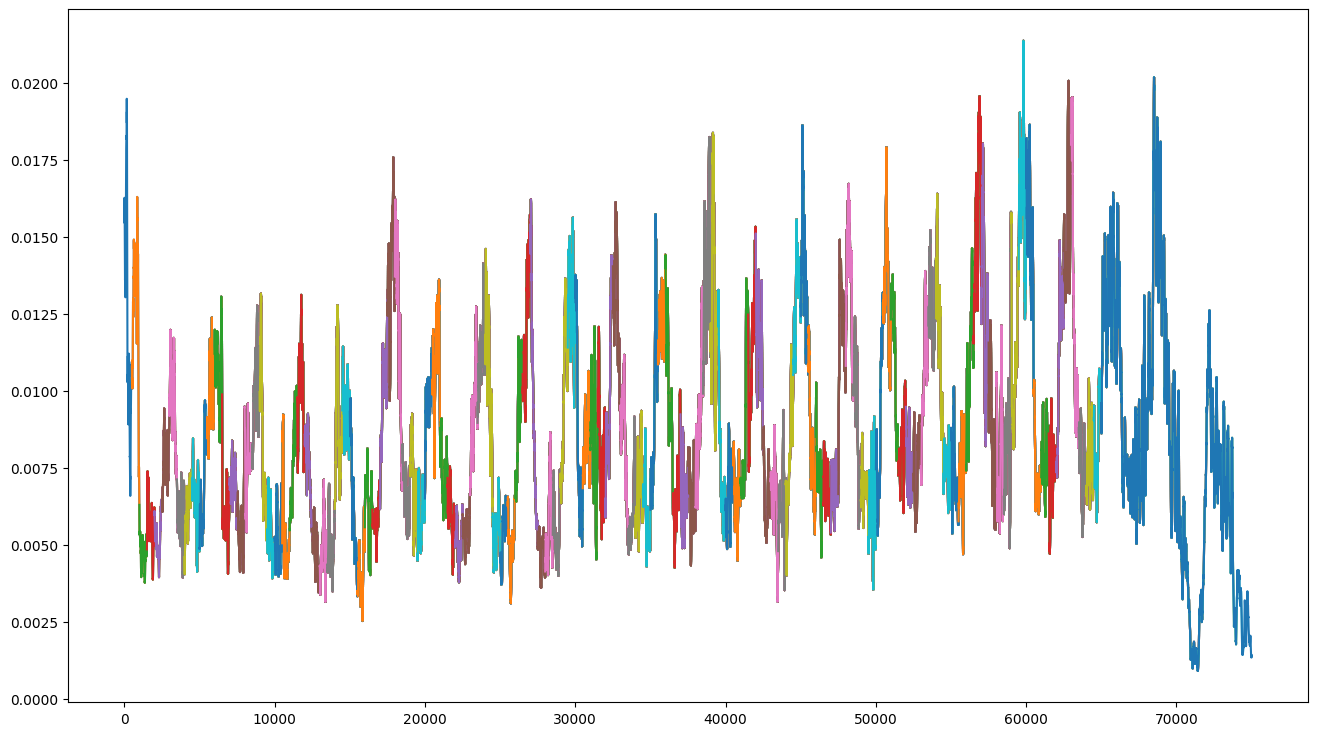

In [13]:
%matplotlib inline
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
i = 0
window = WINDOW_SIZE_SEC*1000
stride = STRIDE_SEC*1000

for signal in inputs["EMG"][0]:
    if MASK_VALUE in signal: continue
    else:
        ax.plot(np.arange(i, i+window), signal)
        i += stride

In [14]:
lstm_blocks = []
shapes = []

for k, v in inputs.items():
    if not USE_CUSTOM_WEIGHTS: weight = None
    elif k == "EMG": weight = 0.25
    elif k == "HR": weight = 0.25
    elif k == "Accelerometer": weight = 0.25
    elif k == "Gyroscope": weight = 0.25
    else: raise NotImplementedError(f"Invalid key: {k}")

    lstm_block = FatigueLSTMBlock(
        weight=weight, 
        mask=MASK_VALUE, 
        lstm_kwargs={"units": 32, "dropout": 0.25, "return_sequences": True}, 
        conv_layers_kwargs=[
            {"filters": 256, "kernel_size": 3, "strides": 1, "padding": "same", "data_format": "channels_last", "activation": "relu"},
            {"filters": 128, "kernel_size": 3, "strides": 1, "padding": "same", "data_format": "channels_last", "activation": "relu"},
            {"filters": 64, "kernel_size": 3, "strides": 1, "padding": "same", "data_format": "channels_last", "activation": "relu"}
        ] if USE_CONV_LAYERS else None
    )

    lstm_blocks.append(lstm_block)

    # Insert "None" as the first element to represent the batch size 
    shapes.append(tuple([None] + list(v.shape[1:])))

fatigue_classifier = FatigueClassifier(lstm_blocks=lstm_blocks)
fatigue_classifier.build(shapes)
fatigue_classifier.summary(expand_nested=True)

I0000 00:00:1742184597.395096   40665 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5029 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:02:00.0, compute capability: 6.1


Model: "fatigue_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fatigue_lstm_block              │ (None, 220, 1)         │     7,815,777 │
│ (FatigueLSTMBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d (Conv1D)            │ (None, 220, 256)       │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_1 (Conv1D)          │ (None, 220, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_2 (Conv1D)          │ (None, 220, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ masking (Masking)          │ (None, 220, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ lstm (LSTM)                │ (None, 220, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense (Dense)              │ (None, 220, 1)         │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fatigue_lstm_block_1            │ (None, 220, 1)         │     1,671,777 │
│ (FatigueLSTMBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_3 (Conv1D)          │ (None, 220, 256)       │     1,536,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_4 (Conv1D)          │ (None, 220, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_5 (Conv1D)          │ (None, 220, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ masking_1 (Masking)        │ (None, 220, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ lstm_1 (LSTM)              │ (None, 220, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_1 (Dense)            │ (None, 220, 1)         │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fatigue_lstm_block_2            │ (None, 220, 1)         │       903,777 │
│ (FatigueLSTMBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_6 (Conv1D)          │ (None, 220, 256)       │       768,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_7 (Conv1D)          │ (None, 220, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_8 (Conv1D)          │ (None, 220, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ masking_2 (Masking)        │ (None, 220, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ lstm_2 (LSTM)              │ (None, 220, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_2 (Dense)            │ (None, 220, 1)         │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fatigue_lstm_block_3            │ (None, 220, 1)         │       903,777 │
│ (FatigueLSTMBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_9 (Conv1D)          │ (None, 220, 256)       │       768,25

 Total params: 11,295,113 (43.09 MB)

 Trainable params: 11,295,113 (43.09 MB)

 Non-trainable params: 0 (0.00 B)

Input shape: $ (N_B, N_T, N_S) $

Where

$N_B = $ batch size,

$N_T = $ timesteps,

$N_S = $ samples

Output shape: $ (N_B, N_T) $

Where

$N_B = $ batch size

$N_T = $ timesteps

In [15]:
optimizer = keras.optimizers.Adam()
fatigue_classifier.compile(optimizer=optimizer, loss=fatigue_classifier.model_loss_function)

In [48]:
history = fatigue_classifier.fit(
    (
        tf.convert_to_tensor(inputs["EMG"], dtype="float32"), 
        tf.convert_to_tensor(inputs["HR"], dtype="float32") * 0.0, 
        tf.convert_to_tensor(inputs["Accelerometer"], dtype="float32"), 
        tf.convert_to_tensor(inputs["Gyroscope"], dtype="float32")
    ),
     tf.convert_to_tensor(outputs, dtype="float32"),
     batch_size=1,
     epochs=100,
     validation_split=0.8
)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0025

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


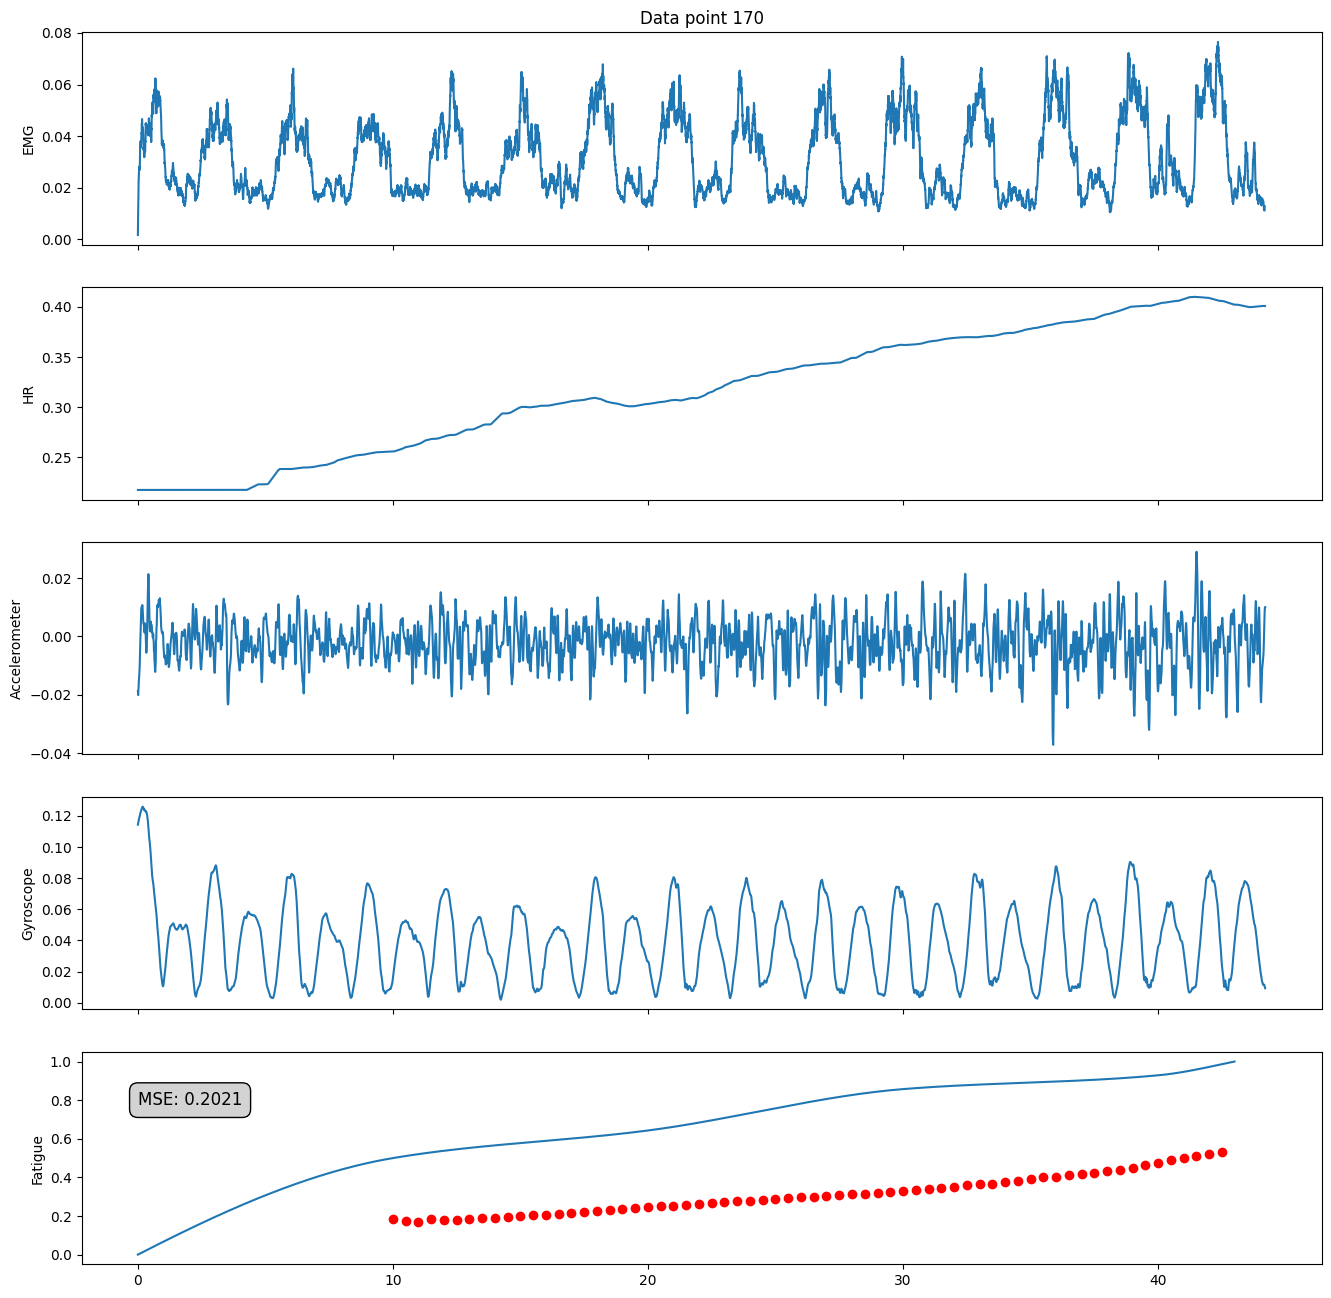

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

signals = ("EMG", "HR", "Accelerometer", "Gyroscope", "Fatigue")
sampling_rates = (SAMPLING_RATE_EMG, SAMPLING_RATE_BPM, SAMPLING_RATE_IMU, SAMPLING_RATE_IMU, SAMPLING_RATE_EMG)

n_images = 1
fig, ax = plt.subplots(len(signals), n_images, sharex=True, figsize=(16,16))
if n_images == 1: ax = ax.reshape((len(signals),1))
data_index = np.random.randint(0, inputs["EMG"].shape[0], (n_images,))

for i in range(n_images):
    ax[0][i].set_title(f"Data point {data_index[i]}")

    for j,name in enumerate(signals):
        a: Axes = ax[j][i]

        if name != "Fatigue":
            signal: NDArray = combined_data[data_index[i]][j]
        else:
            signal: NDArray = combined_labels[data_index[i]]

        signal=signal[np.where(signal != MASK_VALUE)]

        a.plot(
            np.linspace(0.0, sampling_rates[j]*signal.size, signal.size), 
            signal
        )

        ax[j][i].set_ylabel(signals[j])

        if name == "Fatigue":
            out = fatigue_classifier.predict(
                (
                    tf.convert_to_tensor(inputs["EMG"][data_index[i]].reshape([1] + list(inputs["EMG"][0].shape)), dtype="float32"), 
                    tf.convert_to_tensor(inputs["HR"][data_index[i]].reshape([1] + list(inputs["HR"][0].shape)), dtype="float32"), 
                    tf.convert_to_tensor(inputs["Accelerometer"][data_index[i]].reshape([1] + list(inputs["Accelerometer"][0].shape)), dtype="float32"), 
                    tf.convert_to_tensor(inputs["Gyroscope"][data_index[i]].reshape([1] + list(inputs["Gyroscope"][0].shape)), dtype="float32")
                ),
                batch_size=1
            )

            out_pred = copy.deepcopy(out[0, :, 0])
            out_pred=out_pred[np.where(outputs[data_index[i]] != MASK_VALUE)]

            a.scatter(
                np.arange(WINDOW_SIZE_SEC, WINDOW_SIZE_SEC+out_pred.size*STRIDE_SEC, STRIDE_SEC), 
                out_pred,
                c="red"
            )
            
            a.text(0.0, 0.8, f"MSE: {FatigueClassifier.loss(tf.convert_to_tensor(outputs[data_index[i]].reshape((1, outputs[data_index[i]].shape[0], 1)), dtype=tf.float32), out, MASK_VALUE):.4f}", 
                   fontsize=12, ha='left', va='center', bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))


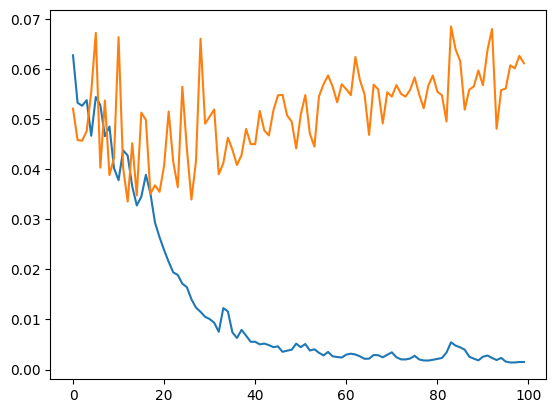

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history["loss"])
ax.plot(history.history["val_loss"])

In [20]:
# %matplotlib inline
# fig = plt.figure()
# ax = fig.add_subplot(111)

# out = fatigue_classifier.predict(
#     (
#         tf.convert_to_tensor(inputs["EMG"][0].reshape([1] + list(inputs["EMG"][0].shape)), dtype="float32") * 0.0, 
#         tf.convert_to_tensor(inputs["HR"][0].reshape([1] + list(inputs["HR"][0].shape)), dtype="float32") * 0.0, 
#         tf.convert_to_tensor(inputs["Accelerometer"][0].reshape([1] + list(inputs["Accelerometer"][0].shape)), dtype="float32") * 0.0, 
#         tf.convert_to_tensor(inputs["Gyroscope"][0].reshape([1] + list(inputs["Gyroscope"][0].shape)), dtype="float32") * 0.0
#     ),
#     batch_size=1
# )

# out_true = copy.deepcopy(outputs[i]) * 0.0
# invalid_indices = (out_true == mask_value)
# out_true[invalid_indices] = np.nan

# out_pred = copy.deepcopy(out[0, :, 0])
# out_pred[invalid_indices] = np.nan

# ax.plot(out_true, label="True")
# ax.plot(out_pred, label="Prediction")
# ax.set_title("Null samples")
# ax.legend()